# Data Loading

In [1]:
# Load the necessary libararies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import dump

# Load the dataset
df = pd.read_excel("D:/[01] SKILLS/[00] Projects/01 Healthcare Premium Prediction/data/raw/raw_premiums_data.xlsx")

# identifying the features for the analysis
customer_features = [
    'Age',
    'Gender',
    'Region',
    'Marital_status',
    'Number Of Dependants',
    'Employment_Status',
    'Income_Level',
    'Income_Lakhs',
]
health_features = [
    'BMI_Category',
    'Smoking_Status',
    'Medical History'
]
plan_features = [
    'Insurance_Plan',
    'Annual_Premium_Amount'
]

# Creating a dataframe copy
df_premiums = df[customer_features + health_features + plan_features].copy()

# Calling first five rows
df_premiums.head()


,Age,Gender,Region,Marital_status,Number Of Dependants,Employment_Status,Income_Level,Income_Lakhs,BMI_Category,Smoking_Status,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Salaried,<10L,6,Normal,No Smoking,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Salaried,<10L,6,Obesity,Regular,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Self-Employed,10L - 25L,20,Normal,No Smoking,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Salaried,> 40L,77,Normal,No Smoking,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Self-Employed,> 40L,99,Overweight,Regular,High blood pressure,Silver,13365


# Data Quality Assessment

## Structural Quality

In [2]:
# Check for shape of the dataframe
print("="*50)
print("Shape of dataframe:")
print("No. of rows:", df_premiums.shape[0])
print("No. of cols:", df_premiums.shape[1])
print("="*50)

# Check for data types
print("Data types of columns:")
print(df_premiums.dtypes)
print("="*50)

# Check for missing values
mv_dict = {
    "no. of missing values" : df_premiums.isnull().sum(),
    "% of missing values": df_premiums.isnull().sum() / df_premiums.shape[0] * 100
}
mv_df = pd.DataFrame(mv_dict)
print("Columns with missing values:")
print(mv_df[mv_df['no. of missing values'] > 0])
print("="*50)

# Check for duplicate records
print("No. of duplicate records:", df_premiums.duplicated().sum())
print("="*50)

Shape of dataframe:
No. of rows: 50000
No. of cols: 13
Data types of columns:
Age                       int64
Gender                   object
Region                   object
Marital_status           object
Number Of Dependants      int64
Employment_Status        object
Income_Level             object
Income_Lakhs              int64
BMI_Category             object
Smoking_Status           object
Medical History          object
Insurance_Plan           object
Annual_Premium_Amount     int64
dtype: object
Columns with missing values:
                   no. of missing values  % of missing values
Employment_Status                      2                0.004
Income_Level                          13                0.026
Smoking_Status                        11                0.022
No. of duplicate records: 0


- column headers follow inconsistent naming convention
- 3 out of 13 columns have missing values but they are negligible and therefore we can drop them.
- there are no duplicated records, but we would still impliment a duplicate handling method for future errors.

## Numeric Columns

In [3]:
# Check for descriptive statistics
num_cols = [
    'Age',
    'Number Of Dependants',
    'Income_Lakhs',
    'Annual_Premium_Amount' # Target Feature
]

df_premiums[num_cols].describe()

,Age,Number Of Dependants,Income_Lakhs,Annual_Premium_Amount
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.593480,1.712080,23.018200,15768.116320
std,15.000437,1.498248,24.219197,8419.839675
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13929.000000
75%,45.000000,3.000000,31.000000,22275.250000
max,356.000000,5.000000,930.000000,43471.000000


- Age column has max value of 356.000000 and "Number Of Dependants" has min value of -3.000000 which are not plausible. This must be due to some technical issue or bug within data collection system.
- Income of 930.000000 Lakhs (~9.3 Crores) is valid but considering mean of 23.018200 and std of 24.219197 it might be an outlier.

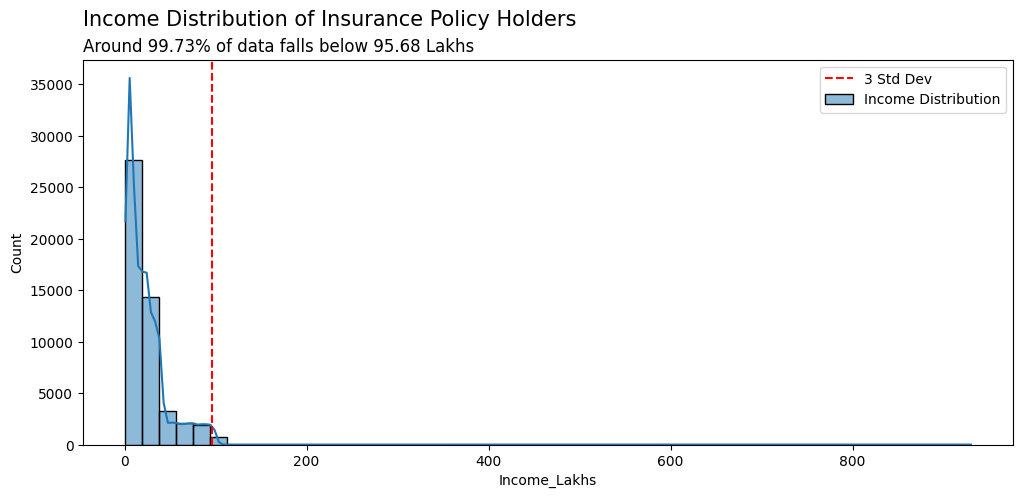

In [4]:
# Finding income value at 3 Std Dev
std_three = df_premiums['Income_Lakhs'].mean() + (3* df_premiums['Income_Lakhs'].std())

# Visualizing income distribution using histogram
plt.figure(figsize= (12,5))
sns.histplot(
    df_premiums['Income_Lakhs'],
    bins= 50,
    kde= True,
    label= "Income Distribution"
)
plt.axvline(std_three, color= 'red', linestyle= "--", label= "3 Std Dev")
plt.legend()

plt.suptitle('Income Distribution of Insurance Policy Holders', x=0.125, ha='left', fontsize= 15)
plt.title(f"Around 99.73% of data falls below {std_three:.2f} Lakhs", x=0.0, ha='left', fontsize= 12)

plt.show()

In [5]:
# Check for % of policy holders below 1 Cr
considered_threshold= 100

pct_before_one_cr = norm.cdf(
    considered_threshold, 
    loc= df_premiums['Income_Lakhs'].mean(), 
    scale= df_premiums['Income_Lakhs'].std()
)

print(f"Percentage of policy holders with income below or equal to 1 Cr : {pct_before_one_cr*100:.2f} %")

Percentage of policy holders with income below or equal to 1 Cr : 99.93 %


We can consider max income threshold to be 100 Lakhs (~1.0 Cr) during model training.

## Categorical Columns

In [6]:
cat_cols = [
    'Gender',
    'Marital_status',
    'Employment_Status',
    'Income_Level',
    'BMI_Category',
    'Smoking_Status',
    'Medical History',
    'Insurance_Plan'
]

for col in cat_cols:
    print(f"{col:<18}: {df_premiums[col].unique().tolist()}")

Gender            : ['Male', 'Female']
Marital_status    : ['Unmarried', 'Married']
Employment_Status : ['Salaried', 'Self-Employed', 'Freelancer', nan]
Income_Level      : ['<10L', '10L - 25L', '> 40L', '25L - 40L', nan]
BMI_Category      : ['Normal', 'Obesity', 'Overweight', 'Underweight']
Smoking_Status    : ['No Smoking', 'Regular', 'Occasional', nan, 'Smoking=0', 'Does Not Smoke', 'Not Smoking']
Medical History   : ['Diabetes', 'High blood pressure', 'No Disease', 'Diabetes & High blood pressure', 'Thyroid', 'Heart disease', 'High blood pressure & Heart disease', 'Diabetes & Thyroid', 'Diabetes & Heart disease']
Insurance_Plan    : ['Bronze', 'Silver', 'Gold']


- Smoking_Status column has three variants of the same variant 'No Smoking'.
- Medical History has two or more values in a single cell, we have to split them into two columns.

# Data Preparation

## Data Cleaning

In [7]:
# Dropping records with missing values
df_premiums.dropna(inplace= True)
mv_dict = {
    "no. of missing values" : df_premiums.isnull().sum(),
    "% of missing values": df_premiums.isnull().sum() / df_premiums.shape[0] * 100
}
mv_df = pd.DataFrame(mv_dict)
print("Columns with missing values:")
print(mv_df[mv_df['no. of missing values'] > 0])
print("="*50)

# Handling duplicate records
df_premiums.drop_duplicates(inplace= True)
print("No. of duplicate records:", df_premiums.duplicated().sum())
print("="*50)

# Handling Anomalies and Outliers
age_filter = df_premiums['Age'] <= 100
df_premiums = df_premiums[age_filter]

income_filter = df_premiums['Income_Lakhs'] <= considered_threshold
df_premiums = df_premiums[income_filter]

df_premiums['Number Of Dependants'] = abs(df_premiums['Number Of Dependants'])

# Correcting inconsistent categories in Smoking_Status
def correct_smoke_status(x):
    if x in ['Smoking=0', 'Does Not Smoke', 'Not Smoking']:
        return 'No Smoking'
    else:
        return x
    
df_premiums['Smoking_Status'] = df_premiums['Smoking_Status'].apply(lambda x: correct_smoke_status(x))

print("Unique values in Smoking Status column:")
print(f"{'Smoking_Status':<18}: {df_premiums['Smoking_Status'].unique().tolist()}")
print("="*50)

# Splitting 'Medical History' column
print("New columns:")
df_premiums[['disease1', 'disease2']] = df_premiums['Medical History'].str.lower().str.split(" & ", expand= True)
df_premiums['disease1'] = df_premiums['disease1'].fillna('none')
df_premiums['disease2'] = df_premiums['disease2'].fillna('none')
print(df_premiums[['disease1', 'disease2']].head(2))
print("="*50)

# Correcting naming convention for column header
df_premiums.columns = df_premiums.columns.str.lower().str.replace(" ","_").tolist()
print("Corrected column headers:")
for col in df_premiums.columns:
    print(col)
print("="*50)


# Checking shape of new dataframe
print("Shape of dataframe:")
print("No. of rows:", df_premiums.shape[0])
print("No. of cols:", df_premiums.shape[1])
print("="*50)


Columns with missing values:
Empty DataFrame
Columns: [no. of missing values, % of missing values]
Index: []
No. of duplicate records: 0
Unique values in Smoking Status column:
Smoking_Status    : ['No Smoking', 'Regular', 'Occasional']
New columns:
   disease1 disease2
0  diabetes     none
1  diabetes     none
Corrected column headers:
age
gender
region
marital_status
number_of_dependants
employment_status
income_level
income_lakhs
bmi_category
smoking_status
medical_history
insurance_plan
annual_premium_amount
disease1
disease2
Shape of dataframe:
No. of rows: 49908
No. of cols: 15


## Feature Engineering

In [8]:
df_premiums.head()

,age,gender,region,marital_status,number_of_dependants,employment_status,income_level,income_lakhs,bmi_category,smoking_status,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Salaried,<10L,6,Normal,No Smoking,Diabetes,Bronze,9053,diabetes,none
1,29,Female,Southeast,Married,2,Salaried,<10L,6,Obesity,Regular,Diabetes,Bronze,16339,diabetes,none
2,49,Female,Northeast,Married,2,Self-Employed,10L - 25L,20,Normal,No Smoking,High blood pressure,Silver,18164,high blood pressure,none
3,30,Female,Southeast,Married,3,Salaried,> 40L,77,Normal,No Smoking,No Disease,Gold,20303,no disease,none
4,18,Male,Northeast,Unmarried,0,Self-Employed,> 40L,99,Overweight,Regular,High blood pressure,Silver,13365,high blood pressure,none


### Feature Encoding

In [9]:
cat_cols_cleaned = df_premiums.select_dtypes('object')
for col in cat_cols_cleaned:
    print(f"{col:<18}: {df_premiums[col].unique().tolist()}")

gender            : ['Male', 'Female']
region            : ['Northwest', 'Southeast', 'Northeast', 'Southwest']
marital_status    : ['Unmarried', 'Married']
employment_status : ['Salaried', 'Self-Employed', 'Freelancer']
income_level      : ['<10L', '10L - 25L', '> 40L', '25L - 40L']
bmi_category      : ['Normal', 'Obesity', 'Overweight', 'Underweight']
smoking_status    : ['No Smoking', 'Regular', 'Occasional']
medical_history   : ['Diabetes', 'High blood pressure', 'No Disease', 'Diabetes & High blood pressure', 'Thyroid', 'Heart disease', 'High blood pressure & Heart disease', 'Diabetes & Thyroid', 'Diabetes & Heart disease']
insurance_plan    : ['Bronze', 'Silver', 'Gold']
disease1          : ['diabetes', 'high blood pressure', 'no disease', 'thyroid', 'heart disease']
disease2          : ['none', 'high blood pressure', 'heart disease', 'thyroid']


- gender, region, marital_status and employment_status are nominal in nature, rest are ordinal.
- therefore, for these columns we can apply one hot encoding and for we can use label encoding.
- for disease1 & disease2 we have to calculate risk score by collaborating with subject matter expert from client side.

In [10]:
# One Hot Encoding
df_premiums = pd.get_dummies(data= df_premiums, columns= ['gender', 'region', 'marital_status', 'employment_status'],dtype= int, drop_first= True)

# Label Encoding
df_premiums['income_level'] = df_premiums['income_level'].map({
                                '<10L' : 0,
                                '10L - 25L': 1,
                                '25L - 40L':2,
                                '> 40L':3
                            })

df_premiums['bmi_category'] = df_premiums['bmi_category'].map({
                                'Underweight':0,
                                'Normal':1,
                                'Overweight':2,
                                'Obesity':3
                            })
df_premiums['smoking_status'] = df_premiums['smoking_status'].map({
                                'No Smoking':0,
                                'Regular':1,
                                'Occasional':2
                            })
df_premiums['insurance_plan'] = df_premiums['insurance_plan'].map({
                                'Bronze':0,
                                'Silver':1,
                                'Gold':2
                            })

# Calculating risk score:
'''
Risk Scores are used to quantify the health risk associated with a policy holder based on their medical history. 
These scores directly influence the amount of premium charged.
'''
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df_premiums['disease1'] = df_premiums['disease1'].map(risk_scores)
df_premiums['disease2'] = df_premiums['disease2'].map(risk_scores)
df_premiums['total_risk_score'] = df_premiums['disease1'] + df_premiums['disease2']

df_premiums.head()

,age,number_of_dependants,income_level,income_lakhs,bmi_category,smoking_status,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,employment_status_Salaried,employment_status_Self-Employed,total_risk_score
0,26,0,0,6,1,0,Diabetes,0,9053,6,0,1,1,0,0,1,1,0,6
1,29,2,0,6,3,1,Diabetes,0,16339,6,0,0,0,1,0,0,1,0,6
2,49,2,1,20,1,0,High blood pressure,1,18164,6,0,0,0,0,0,0,0,1,6
3,30,3,3,77,1,0,No Disease,2,20303,0,0,0,0,1,0,0,1,0,0
4,18,0,3,99,2,1,High blood pressure,1,13365,6,0,1,0,0,0,1,0,1,6


### Feature Scaling

In [11]:
cols_to_scale = df_premiums.drop(columns= ['medical_history', 'annual_premium_amount']).columns.to_list()

scaler = MinMaxScaler()

df_premiums[cols_to_scale] = scaler.fit_transform(df_premiums[cols_to_scale])
df_premiums.head()

,age,number_of_dependants,income_level,income_lakhs,bmi_category,smoking_status,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,employment_status_Salaried,employment_status_Self-Employed,total_risk_score
0,0.148148,0.0,0.000000,0.050505,0.333333,0.0,Diabetes,0.0,9053,0.75,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.428571
1,0.203704,0.4,0.000000,0.050505,1.000000,0.5,Diabetes,0.0,16339,0.75,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.428571
2,0.574074,0.4,0.333333,0.191919,0.333333,0.0,High blood pressure,0.5,18164,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.428571
3,0.222222,0.6,1.000000,0.767677,0.333333,0.0,No Disease,1.0,20303,0.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000
4,0.000000,0.0,1.000000,0.989899,0.666667,0.5,High blood pressure,0.5,13365,0.75,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.428571


### Feature Selection

In [12]:
# Manually dropping columns
df_premiums.drop(columns= ['medical_history', 'disease1', 'disease2'], inplace= True)

In [13]:
# Calculating VIF:
def cal_vif(df):
    vif_dict = {
        'features': df.columns.to_list(),
        'vif': [variance_inflation_factor(exog= df, exog_idx= i) for i in range(len(df.columns.to_list()))]
        }

    vif_df = pd.DataFrame(vif_dict)
    return vif_df


vif_df = cal_vif(
    df_premiums.drop(columns=[
        'annual_premium_amount', # Target
        'income_level', # high VIF feature
    ])
)
vif_df

,features,vif
0,age,4.585405
1,number_of_dependants,4.657605
2,income_lakhs,2.478558
3,bmi_category,3.381579
4,smoking_status,1.756720
5,insurance_plan,3.444405
6,gender_Male,2.219179
7,region_Northwest,2.103115
8,region_Southeast,2.923537
9,region_Southwest,2.671398


In [14]:
# dropping volumns with high VIF
df_premiums.drop(columns=['income_level'],inplace= True)

# Processed Data

In [15]:
df_premiums.head()

,age,number_of_dependants,income_lakhs,bmi_category,smoking_status,insurance_plan,annual_premium_amount,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,employment_status_Salaried,employment_status_Self-Employed,total_risk_score
0,0.148148,0.0,0.050505,0.333333,0.0,0.0,9053,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.428571
1,0.203704,0.4,0.050505,1.000000,0.5,0.0,16339,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.428571
2,0.574074,0.4,0.191919,0.333333,0.0,0.5,18164,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.428571
3,0.222222,0.6,0.767677,0.333333,0.0,1.0,20303,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000
4,0.000000,0.0,0.989899,0.666667,0.5,0.5,13365,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.428571


## Exporting data

In [16]:

# Exporting processed data
df_premiums.to_excel(
    "D:/[01] SKILLS/[00] Projects/01 Healthcare Premium Prediction/data/processed/processed_premiums_data.xlsx", 
    index= False
)

# Exporting scaler object
scaler_cols = {
    'scaler':scaler,
    'cols_to_scale': cols_to_scale
}

dump(
    value= scaler_cols,
    filename= 'D:/[01] SKILLS/[00] Projects/01 Healthcare Premium Prediction/models/scaler_obj_overall.joblib'
)

['D:/[01] SKILLS/[00] Projects/01 Healthcare Premium Prediction/models/scaler_obj_overall.joblib']